# Graph-to-Hypergraph Modularity Maximization Lifting Tutorial

***
This notebook shows how to import a dataset, with the desired lifting, and how to run a neural network using the loaded data.

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the data and the desired tranformation, createsa a dataset object and visualizes it.
- [Loading and applying the lifting](#loading-and-applying-the-lifting) defines a simple neural network to test that the lifting creates the expected incidence matrices.
- [Create and run a simplicial nn model](#create-and-run-a-simplicial-nn-model) simply runs a forward pass of the model to check that everything is working as expected.

***
***

Note that for simplicity the notebook is setup to use a simple graph. However, there is a set of available datasets that you can play with.

To switch to one of the available datasets, simply change the *dataset_name* variable in [Dataset config](#dataset-config) to one of the following names:

* cocitation_cora
* cocitation_citeseer
* cocitation_pubmed
* MUTAG
* NCI1
* NCI109
* PROTEINS_TU
* AQSOL
* ZINC
***

### Imports and utilities

In [1]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2

from modules.data.load.loaders import GraphLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_model_config,
    load_transform_config,
)

## Loading the Dataset

Here we just need to spicify the name of the available dataset that we want to load. First, the dataset config is read from the corresponding yaml file (located at `/configs/datasets/` directory), and then the data is loaded via the implemented `Loaders`.


In [2]:
dataset_name = "manual_dataset"
dataset_config = load_dataset_config(dataset_name)
loader = GraphLoader(dataset_config)


Dataset configuration for manual_dataset:

{'data_domain': 'graph',
 'data_type': 'toy_dataset',
 'data_name': 'manual',
 'data_dir': 'datasets/graph/toy_dataset',
 'num_features': 1,
 'num_classes': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'node'}


We can then access to the data through the `load()`method:


Dataset only contains 1 sample:


Processing...
Done!


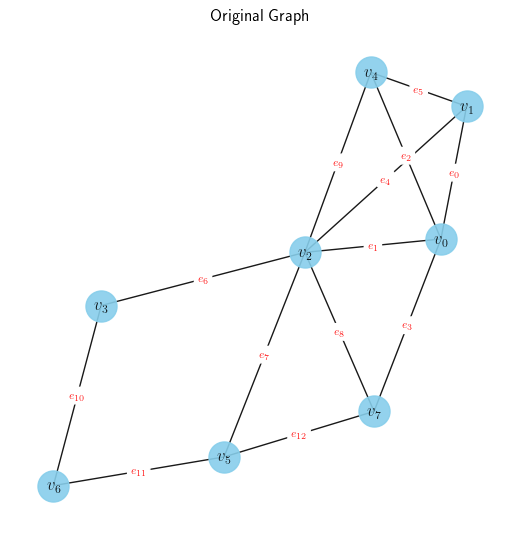

 - Graph with 8 vertices and 13 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.



In [3]:
dataset = loader.load()
describe_data(dataset)

## Loading and Applying the Lifting

In this section, we will instantiate the ModularityMaximizationLifting method to apply to the data. This method is inspired by the spectral approach to modularity maximization for community detection, as described in the paper "Spectral methods for network community detection and graph partitioning" by M. E. J. Newman [1]. This method extends the approach described in [1] by applying k-means clustering to the leading eigenvectors of the modularity matrix, allowing for the detection of more than two communities. This modification enables the algorithm to handle more complex community structures while still using the spectral properties of the modularity matrix.

The ModularityMaximizationLifting algorithm works as follows:

1. Compute the modularity matrix B of the graph, as defined in equation (4) of [1]:

   $$B_{ij} = A_{ij} - \frac{k_i k_j}{2m}$$

   where A is the adjacency matrix, k_i is the degree of node i, and m is the total number of edges.

2. Perform spectral clustering on B to detect communities:
   - Compute the leading eigenvectors of B
   - Apply k-means clustering to these eigenvectors

Note: The k-means clustering step involves random initialization, which introduces non-determinism into the algorithm. As a result, the detected communities and resulting hyperedges may vary slightly between different runs of the algorithm on the same input data.



3. For each node i, create a hyperedge H_i containing:
   - Node i itself
   - The k nearest neighbors of i within its detected community

The algorithm is initialized with default parameters num_communities=2 and k_neighbors=3, but these can be adjusted to suit different network structures needs.

This lifting is based on both the graph structure and the initial features of the nodes. It creates a hypergraph with the same number of hyperedges as the number of nodes in the original graph, but the size of each hyperedge can vary depending on the community structure.

The computational complexity of the algorithm is approximately O(n^2 + nk + nct), where n is the number of nodes in the graph, k is the number of nearest neighbors considered, c is the number of communities, and t is the number of iterations in k-means clustering. The n^2 term comes from the eigendecomposition of the modularity matrix, nk is from the nearest neighbor calculations within communities, and nct represents the k-means clustering step.

This method aims to preserve the community structure of the original graph in the lifted hypergraph, potentially allowing for more detailed representations of complex network structures. This method is particularly suitable for cases in which the global structure and community organization of the graph are important.

For hypergraphs, creating a lifting involves creating the `incidence_hyperedges` matrix.

As before, we can specify the transformation we want to apply through its type and id in the corresponding config files located at `/configs/transforms`.

Note that the *transform_config* dictionary generated below can contain a sequence of transforms if needed. This can also be used to explore liftings from one topological domain to another, for example using two liftings it is possible to achieve a sequence such as: graph -> simplicial complex -> hypergraph.

***
[1] Newman, M. E. J. (2013). Spectral methods for network community detection and graph partitioning. Physical Review E, 88(4), 042822. https://arxiv.org/abs/1307.7729
***


In [4]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "graph2hypergraph/modularity_maximization_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for graph2hypergraph/modularity_maximization_lifting:

{'transform_type': 'lifting',
 'transform_name': 'ModularityMaximizationLifting',
 'k_value': None,
 'feature_lifting': 'ProjectionSum'}


We than apply the transform via our `PreProcesor`:


Dataset only contains 1 sample:


Processing...
Done!


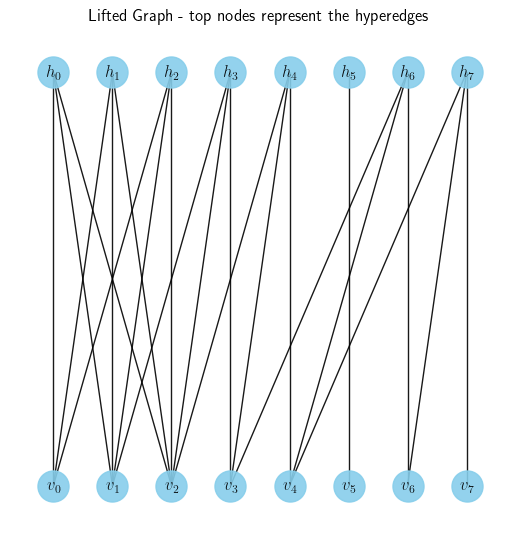

 - Hypergraph with 8 vertices and 8 hyperedges.
 - The nodes have feature dimensions 1.
 - The hyperedges have feature dimensions 1.



In [5]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)

## Create and Run a Simplicial NN Model

In this section a simple model is created to test that the used lifting works as intended. In this case the model uses the `incidence_hyperedges` matrix so the lifting should make sure to add it to the data.

In [6]:
from modules.models.hypergraph.unigcn import UniGCNModel

model_type = "hypergraph"
model_id = "unigcn"
model_config = load_model_config(model_type, model_id)

model = UniGCNModel(model_config, dataset_config)


Model configuration for hypergraph UNIGCN:

{'in_channels': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2}


In [7]:
y_hat = model(lifted_dataset.get(0))

If everything is correct the cell above should execute without errors.

## Example on a bigger dataset

In [8]:
dataset_name = "MUTAG"
dataset_config = load_dataset_config(dataset_name)
loader = GraphLoader(dataset_config)


Dataset configuration for MUTAG:

{'data_domain': 'graph',
 'data_type': 'TUDataset',
 'data_name': 'MUTAG',
 'data_dir': 'datasets/graph/TUDataset',
 'num_features': [7, 4],
 'num_classes': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'graph',
 'max_dim_if_lifted': 2,
 'preserve_edge_attr_if_lifted': False}


Processing...
Done!



Dataset contains 188 samples.

Providing more details about sample 0/188:


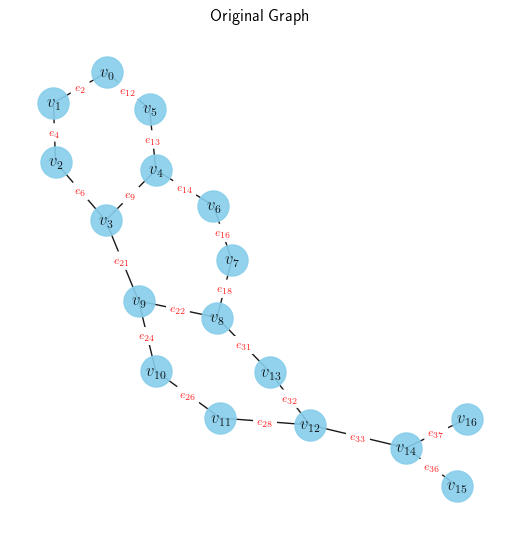

 - Graph with 17 vertices and 38 edges.
 - Features dimensions: [7, 4]
 - There are 0 isolated nodes.



In [9]:
dataset = loader.load()
describe_data(dataset)

Processing...
Done!



Dataset contains 188 samples.

Providing more details about sample 0/188:


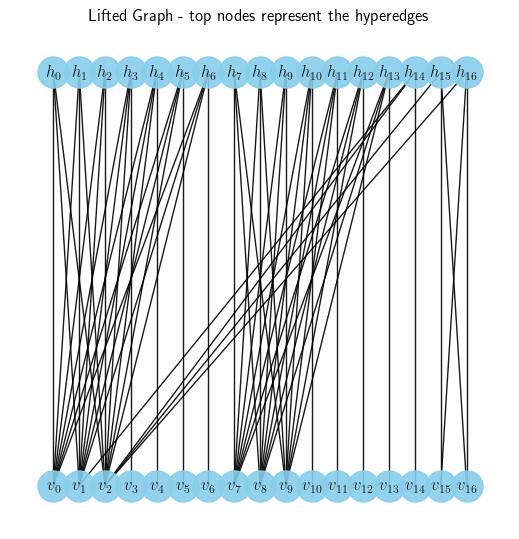

 - Hypergraph with 17 vertices and 17 hyperedges.
 - The nodes have feature dimensions 7.
 - The hyperedges have feature dimensions 7.



In [10]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)

## Running the Simplicial NN model on the bigger dataset

In [11]:
from modules.models.hypergraph.unigcn import UniGCNModel

model_type = "hypergraph"
model_id = "unigcn"
model_config = load_model_config(model_type, model_id)

model = UniGCNModel(model_config, dataset_config)


Model configuration for hypergraph UNIGCN:

{'in_channels': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2}


In [12]:
y_hat = model(lifted_dataset.get(0))

If everything is correct the cell above should execute without errors.